In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torchvision.models as models
import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
#the size of our mini batches
batch_size     = 32
#How many iterations of our dataset
num_epochs     = 10
#optimizer learning rate
learning_rate  = 1e-6
#initialise what epoch we start from
start_epoch    = 0
#initialise best valid accuracy
best_valid_acc = 0
#where to load/save the dataset from
data_set_root  = "data_dir"
#what to resize our images to
image_size     = 224

In [3]:
save_checkpoint = False
start_from_checkpoint = False
save_dir = 'Models'
model_name = 'Res_18_STL10'

In [4]:
# Set device to GPU_indx if GPU is available
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Data Augmentation

In [5]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomCrop(image_size),      #Random crop
            transforms.RandomHorizontalFlip(p=0.5), #random horizontal flip with 50% chance
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

## Load the data

In [6]:
data_dir = "/content/drive/MyDrive/casting_data"

## Showing the images

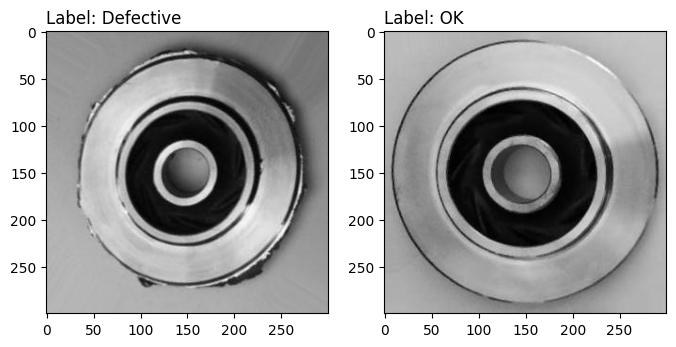

In [7]:
# Define the directories for training and testing data
dir_train_def = "/content/drive/MyDrive/casting_data/train/def_front/"
dir_train_ok = "/content/drive/MyDrive/casting_data/train/ok_front/"
dir_test_def = "/content/drive/MyDrive/casting_data/test/def_front/"
dir_test_ok = "/content/drive/MyDrive/casting_data/test/ok_front/"



# Plotting data
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sample_def = plt.imread(dir_train_def+os.listdir(dir_train_def)[0])
sample_ok = plt.imread(dir_train_ok+os.listdir(dir_train_ok)[0])
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title("Label: Defective", loc="left")
axes[1].set_title("Label: OK", loc="left")
axes[0].grid(False)
axes[1].grid(False)
plt.show()


## Showing the data distribution

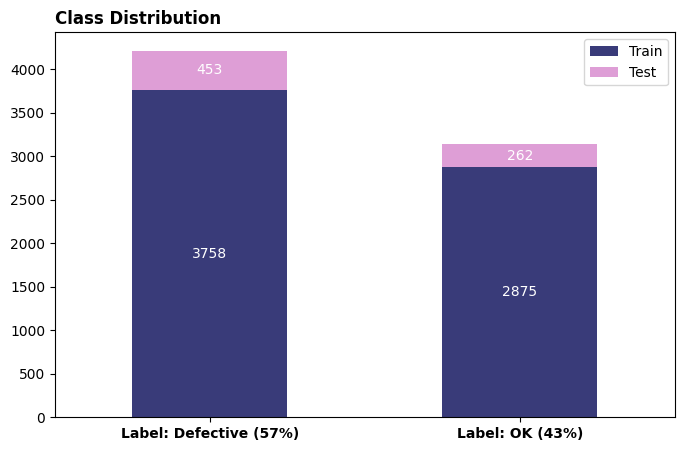

In [8]:
# Data distribution
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(data=[n_train, n_test],
                       columns=["Defective", "OK"],
                       index=["Train", "Test"])

# Visualize class distribution
ax = dist_df.T.plot(kind="bar", stacked=True, rot=0, figsize=(8,5), colormap="tab20b")
ax.set_title("Class Distribution", loc="left", weight="bold")
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25,
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha="center", va="center", color="white")
pct_def = 100 * dist_df["Defective"].sum() / dist_df.values.sum()
pct_ok = 100 - pct_def
ax.set_xticklabels([f"Label: Defective ({pct_def:.0f}%)",
                    f"Label: OK ({pct_ok:.0f}%)"], weight="bold")
plt.show()


## Define the data directories

In [9]:
train_data = ImageFolder("/content/drive/MyDrive/casting_data/train", transform=transform)
print(train_data.class_to_idx)

test_data = ImageFolder("/content/drive/MyDrive/casting_data/test", transform=transform)
print(test_data.class_to_idx)


{'def_front': 0, 'ok_front': 1}
{'def_front': 0, 'ok_front': 1}


In [10]:
len(train_data)

6633

## Creating Validation data

In [11]:
#Split trainging data into train and validation set with 90/10% traning/validation split
validation_split = 0.8


#Define the train, validation, and test splits
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])




In [12]:
# Print the number of samples in each split
print("Train samples:", len(train_data))
print("Validation samples:", len(val_data))
print("Test samples:", len(test_data))

Train samples: 5306
Validation samples: 1327
Test samples: 715


## Create the dataloader

In [13]:
# Create DataLoader instances for train, validation, and test datasets

train_loader = dataloader(train_data, batch_size=batch_size, shuffle=True)
val_loader = dataloader(val_data, batch_size=batch_size, shuffle=False)
test_loader = dataloader(test_data, batch_size=batch_size, shuffle=False)


In [14]:
#This Function will allow us to scale an images pixel values to a value between 0 and 1
def normalize_img(img):
    mins = img.min(0, keepdims = True).min(1, keepdims = True)
    maxs = img.max(0, keepdims = True).max(1, keepdims = True)
    return (img - mins)/(maxs - mins)

## Visualise the data

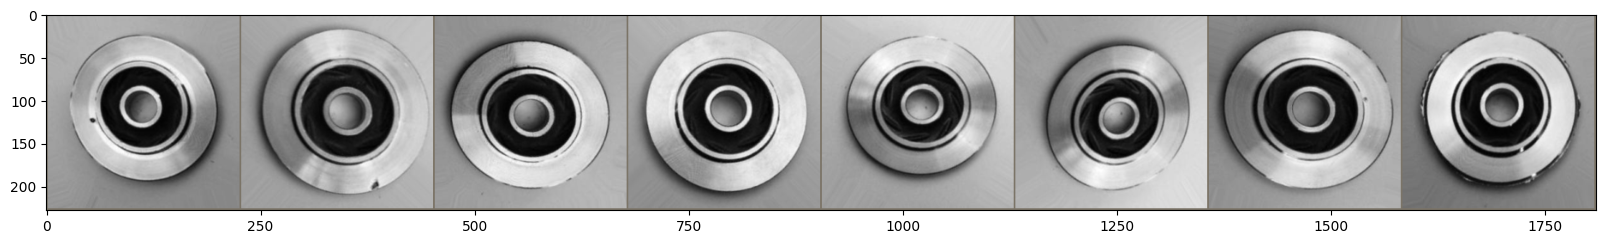

In [15]:
plt.figure(figsize = (20,10))
images, labels = next(iter(train_loader))
out = torchvision.utils.make_grid(images[0:8])
plt.imshow(normalize_img(out.numpy().transpose((1, 2, 0))))

## Create the pretrained network

In [16]:
Res_net = models.resnet18(pretrained=True).to(device)

# Modify the first convolutional layer to accept single-channel inputs
#Res_net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 57.6MB/s]


In [17]:

# Verify the architecture
print(Res_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
#Augment the model, by swapping out the last fc layer for a different one
#get the number of in_features into the last fc layer
num_ftrs = Res_net.fc.in_features
#redefine the last fc layer with a linear layer with 2 ouputs, this layer's weights will be randomly initialised
Res_net.fc = nn.Linear(num_ftrs, 2).to(device)

In [19]:
#pass image through network
out = Res_net(images.to(device))
#check output
out.shape

torch.Size([32, 2])

## set up the optimizer

In [20]:
#Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(Res_net.parameters(), lr = learning_rate)

In [21]:
#Define a Cross Entropy Loss
Loss_fun = nn.CrossEntropyLoss()
#Loss_fun = nn.BCELoss()

## Define the accuracy calculator

In [22]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

## Define the training process

In [23]:
#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, loss_fun, loss_logger):

    #initialise counters
    epoch_loss = 0
    epoch_acc = 0

    #Set Network in train mode
    net.train()

    for i, (x, y) in enumerate(loader):

        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label

        #Forward pass of image through network and get output
        fx = net(x)

        #y = y.unsqueeze(1)   # Reshape target tensor to [32, 1]

        #Calculate loss using loss function
        loss = loss_fun(fx, y)

        #calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()

        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #log the loss for plotting
        loss_logger.append(loss.item())


        #clear_output is a handy function from the IPython.display module
        #it simply clears the output of the running cell

        clear_output(True)
        print("TRAINING: | Itteration [%d/%d] | Loss %.2f |" %(i+1 ,len(loader) , loss.item()))

    #return the avaerage loss and acc from the epoch as well as the logger array
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

## Define the testing process

In [24]:


#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, loss_fun, loss_logger = None):

    epoch_loss = 0
    epoch_acc = 0
    correct_predictions = 0
    total_samples = 0
    true_labels = []
    predicted_labels = []

    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):

            #load images and labels to device
            x = x.to(device)
            y = y.to(device)

            #Forward pass of image through network
            fx = net(x)

            #Calculate loss using loss function
            loss = loss_fun(fx, y)

            #calculate the accuracy
            acc = calculate_accuracy(fx, y)

            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())

            #obtain the predicted labels and true labels during evaluation.
            _, predicted = torch.max(fx, 1)

            correct_predictions += (predicted == y).sum().item()
            total_samples += y.size(0)

            correct_predictions = acc * total_samples
            total_samples = correct_predictions / acc

            true_labels.extend(y.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())



            clear_output(True)
            print("EVALUATION: | Itteration [%d/%d] | Loss %.2f | Accuracy %.2f%% |" %(i+1 ,len(loader), loss.item(), 100*(epoch_acc/ len(loader))))

    #return the avaerage loss and acc from the epoch as well as the logger array
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger




##  Learning rate scheduler

In [25]:
#Create a function that will linearly decay the learning rate every epoch
def lr_linear_decay(epoch_max, epoch, lr):
    lr_adj = ((epoch_max - epoch)/epoch_max)*lr
    #update the learning rate parameter of the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_adj

## The training process

In [26]:
#Log the training and validation losses
training_loss_logger = []
validation_loss_logger = []

In [27]:
#This cell implements our training loop

#Record the start time
Start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    #Implement the linear decay of the learning rate
    lr_linear_decay(num_epochs, epoch, learning_rate)

    #call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger = train(Res_net, device, train_loader, optimizer, Loss_fun, training_loss_logger)

    #call the evaluate function and pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger = evaluate(Res_net, device, val_loader, Loss_fun, validation_loss_logger)

    #If this model has the highest performace on the validation set
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > best_valid_acc) and save_checkpoint:
        print("Saving Model")
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      Res_net.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(),
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }, save_path)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

End_time = time.time()

EVALUATION: | Itteration [42/42] | Loss 0.16 | Accuracy 98.72% |
| Epoch: 10 | Train Loss: 0.076 | Train Acc: 99.00% | Val. Loss: 0.073 | Val. Acc: 98.72% |


In [28]:
print("Training time %.2f seconds" %(End_time - Start_time))

Training time 1314.69 seconds


## Plot the training and testing loss

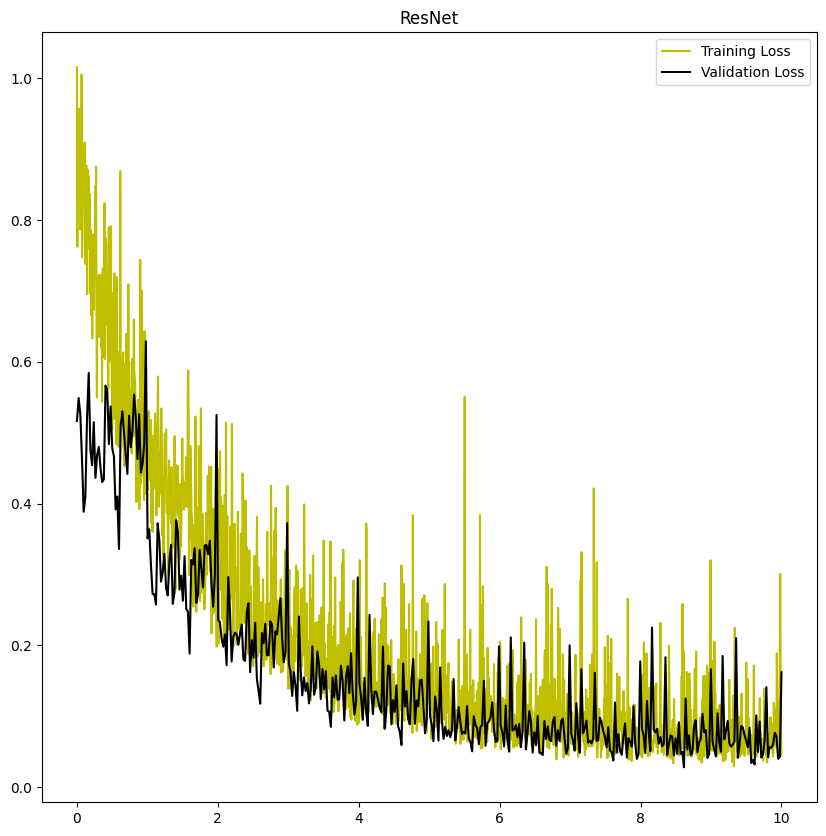

In [29]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")

plt.title("ResNet")
plt.legend(["Training Loss", "Validation Loss"])

## Evaluate

In [30]:
#call the evaluate function and pass the evaluation/test dataloader etc
test_loss, test_acc, _ = evaluate(Res_net, device, test_loader, Loss_fun)

EVALUATION: | Itteration [23/23] | Loss 0.02 | Accuracy 99.46% |


## Confusion Matrix

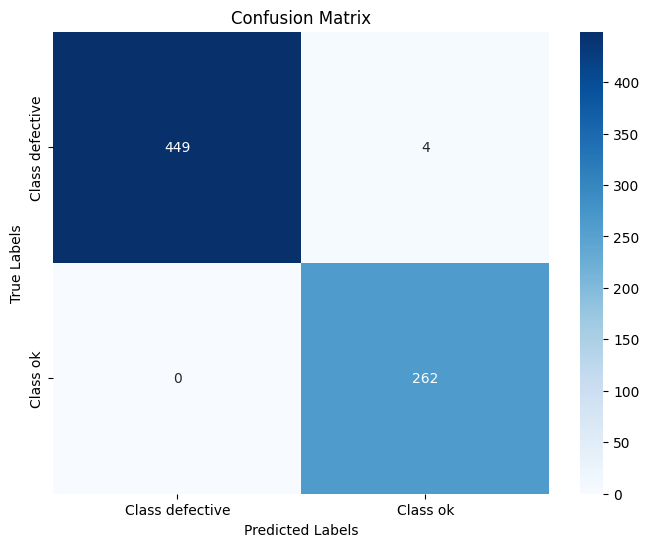

Classification Report:
                 precision    recall  f1-score   support

Class defective       1.00      0.99      1.00       453
       Class ok       0.98      1.00      0.99       262

       accuracy                           0.99       715
      macro avg       0.99      1.00      0.99       715
   weighted avg       0.99      0.99      0.99       715



In [34]:
# Obtain predictions
class_labels = ['Class defective', 'Class ok']
predictions = []
true_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = Res_net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


target_names = ['Class defective', 'Class ok']
classification_rep = classification_report(true_labels, predictions, target_names=target_names)
print("Classification Report:")
print(classification_rep)
